In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf 
import keras
from keras import backend as K
import cv2
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add,concatenate
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical ,Sequence
 
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from keras.optimizers import Adadelta, Nadam ,Adam
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Reshape ,MaxPooling2D, advanced_activations
from keras.layers import concatenate, Concatenate,Dense, Flatten,SeparableConv2D,LeakyReLU,GlobalAveragePooling2D
from keras.layers import BatchNormalization, RepeatVector, Permute, Activation, Reshape, Flatten,Multiply
from keras.layers.advanced_activations import PReLU

import os
 
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice
#from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add


# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


## EDA

In [2]:
dataset_path = Path("D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/")
datasetg_path = Path("D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/Bag/")
list(dataset_path.iterdir())

[WindowsPath('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/Bag'),
 WindowsPath('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/test'),
 WindowsPath('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/test_labels'),
 WindowsPath('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/train'),
 WindowsPath('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/train_labels'),
 WindowsPath('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/val'),
 WindowsPath('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/val_labels')]

In [3]:
def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')       
#tree(dataset_path)

In [4]:
train_imgs = list((datasetg_path / "train").glob("*.png"))
train_labels = list((datasetg_path / "train_l").glob("*.png"))
val_imgs = list((datasetg_path / "val").glob("*.png"))
val_labels = list((datasetg_path / "val_l").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)) , (len(test_imgs),len(test_labels))

img_size = 256

In [5]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [6]:
for im in train_imgs:
    assert datasetg_path / "train_l" / (im.stem +".png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert datasetg_path / "val_l" / (im.stem +".png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [7]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +".png")))
    
    return pairs

def make_pairt(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [8]:
train_pair = make_pair(train_imgs, "train_l", datasetg_path)
val_pair = make_pair(val_imgs, "val_l", datasetg_path)
test_pair = make_pairt(test_imgs, "test_labels", dataset_path)

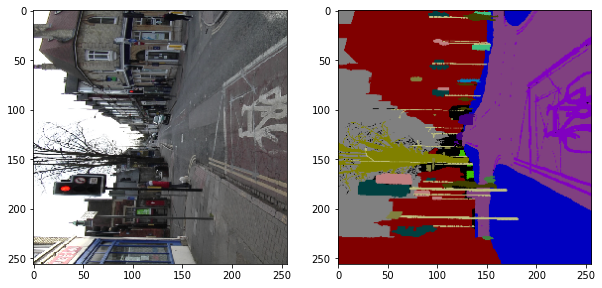

In [9]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [10]:
class_map_df = pd.read_csv("class_dict.csv")

In [11]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
len(class_map)

32

In [12]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [13]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [14]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 0,  2,  4,  5,  8, 10, 12, 14, 15, 16, 17, 19, 20, 21, 24, 26, 30,
        31], dtype=uint8),
 array([ 3568,    52, 19465,   190,   916,  2621,   264,    18,   129,
          484, 16081,  9071,   523,  7881,  1218,  2050,   922,    83],
       dtype=int64))

In [15]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [16]:
train_generator = DataGenerator(train_pair+test_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

519

In [17]:
X,y = train_generator.__getitem__(1)
y.shape

(4, 256, 256, 32)

In [18]:
val_generator = DataGenerator(val_pair, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

100

In [19]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x2 = Conv2D(filters=nfilters, kernel_size=(5, 5), padding=padding, kernel_initializer=initializer)(tensor)
    x3 = Conv2D(filters=nfilters, kernel_size=(7, 7), padding=padding, kernel_initializer=initializer)(tensor)
    y=w3(tensor,nfilters)
    y1=w3(y,nfilters)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    cx = concatenate([y,x,y1],axis=3)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(cx)
    x=add([x,x3,x2])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def w3(x,f):
    c1 = Conv2D(f, (3, 3), activation='relu', padding='same')(x)

    c2 = Conv2D(f, (3, 3), activation='relu', padding='same')(c1)
    d1 = Conv2DTranspose(f, (3, 3), activation='relu', padding='same')(c2)

    m1 = concatenate([d1, c2],axis=3)

    d2 = Conv2DTranspose(f, (3, 3), activation='relu', padding='same')(m1)

    m2 = concatenate([c1, d2],axis=3)

    out = Conv2D(f, (3, 3), activation='sigmoid', padding='same')(m2)
    return out



def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=32, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [20]:
model = Unet(img_size , img_size , 16)
#model.summary()

In [21]:
 
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

def dice1(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[0])
  union = K.sum(y_true, axis=[0]) + K.sum(y_pred, axis=[0])
  dicef = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dicef


def dicec(y_true, y_pred):
    return(0.5*(dice1(y_true, y_pred, smooth=1)+dice_coef(y_true, y_pred)))



model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',dicec])

In [22]:
 
es = EarlyStopping(mode='max', monitor='val_acc', patience=10, verbose=0)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
 
 

In [23]:
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 6,
                              verbose = 1,
                              mode="max",
                              min_delta = 0.0001)

filepath="B_cam.hdf5"
chp = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
 
 


In [75]:
results = model.fit_generator(train_generator , steps_per_epoch=train_steps ,epochs=1000,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[rl,chp ])

Epoch 1/1000
519/519 [==============================] - 238s 458ms/step - loss: 0.6457 - accuracy: 0.8160 - dicec: 0.8458 - val_loss: 0.4661 - val_accuracy: 0.8294 - val_dicec: 0.8576

Epoch 00001: val_loss did not improve from 4.27140
Epoch 2/1000
 18/519 [>.............................] - ETA: 3:20 - loss: 0.6258 - accuracy: 0.8231 - dicec: 0.8488

KeyboardInterrupt: 

In [43]:
img_mask = choice(val_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

In [44]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [45]:
pred_label = make_prediction(model, img_mask[0], (img_size,img_size,3))
pred_label.shape

(256, 256)

In [46]:
# img1 = np.expand_dims(img,axis=0)
# labels = model.predict(img1)[0]
# #labels = np.argmax(labels,axis=2)
 

In [47]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [48]:
pred_colored = form_colormap(pred_label,np.array(class_map))

In [53]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c
    

    
    


In [54]:
label_codes, label_names =zip(*[parse_code(l) for l in open("label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [55]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [56]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image

def meanIOU(y_target,y_output):
    assert len(y_output) == len(y_target)
    epsilon = 0.001
    iouSum = 0
    for out, targ in zip(y_output, y_target):
        binary = out>0 #torch.where(out>0,1,0)
        #binary = torch.round(y_input) #threshold at 0.5
        intersection = (binary * targ).sum()
        union = (binary + targ).sum() - intersection
        iouSum += (intersection+epsilon) / (union+epsilon)
    return iouSum / float(len(y_output)) 

Text(0.5, 1.0, 'predicted labels')

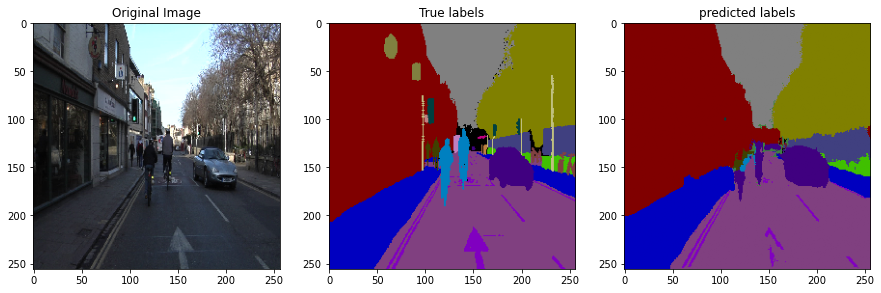

In [76]:
img_mask = choice(test_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))
pred_label = make_prediction(model, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))


plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

In [77]:
yt=rgb_to_onehot(gt_img, colormap = id2code)
yp=rgb_to_onehot(pred_colored, colormap = id2code)



 

In [78]:
 (meanIOU(yt,yp))

0.8438016215388412

In [79]:
img_mask = choice(test_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))
pred_label = make_prediction(model, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))

In [80]:
gh= np.array(glob('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/test/*.png'))
nh= np.array(glob('D:/1A work/jupyter/udac/1_semantic_seg/B_cam/CamVid/cmvidata/test_labels/*.png'))

In [92]:
score=list()
gt=list()
pt=list()

for i in range(len(gh)):
   
         img= img_to_array(load_img(gh[i] , target_size= (img_size,img_size)))
         gt_img = img_to_array(load_img(nh[i] , target_size= (img_size,img_size)))
         pred_label = make_prediction(model, gh[i], (img_size,img_size,3))
         pred_colored = form_colormap(pred_label,np.array(class_map))
         yt=rgb_to_onehot(gt_img, colormap = id2code)
         yp=rgb_to_onehot(pred_colored, colormap = id2code)
         m_iou_score= meanIOU(yt,yp) 
         #print(m_iou_score)
         score.append(m_iou_score)
         gt.append(gt_img )
         pt.append(pred_colored )



In [93]:
g1=np.asarray(gt)
p1=np.asarray(pt)

mr=np.asarray(score)
mr.mean()

0.7361381610129535

In [95]:
p1.shape

(232, 256, 256, 3)

In [96]:
score


[0.5192081264703167,
 0.5997817508343789,
 0.6088741801435777,
 0.6880293672271978,
 0.5753371072776383,
 0.5429427168889136,
 0.5397537924749772,
 0.48300245032430866,
 0.5338091303842579,
 0.5998133237768936,
 0.5364719253866318,
 0.6291691575507575,
 0.6211590985787148,
 0.5487551505798829,
 0.47059572795586657,
 0.5170337732754948,
 0.5921787146353075,
 0.6227380466954809,
 0.5927058359293126,
 0.7158689649420107,
 0.7419786073878353,
 0.7122130937437016,
 0.7147866075393547,
 0.6893194859359194,
 0.70164824002683,
 0.7327609695396696,
 0.6914234356137603,
 0.7619284981070309,
 0.6755716410529686,
 0.6799551052266107,
 0.7203257853988669,
 0.7538642355276503,
 0.7414511910191137,
 0.728005441045709,
 0.6876982609059371,
 0.6394329551490647,
 0.7686000930873432,
 0.7823548168938816,
 0.7668691155917492,
 0.7924437274760862,
 0.8152590431546298,
 0.8180713415952061,
 0.7922774447564379,
 0.7863715508249256,
 0.7939498545867496,
 0.8183465616021063,
 0.8127854296497332,
 0.80305306733

(2, 256, 256, 3)